In [1]:
# From https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
import re
import pathlib
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

# Similarity Measures for ETD Abstracts
Using this [blog post](https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630) as a guide, this notebook replicates the generation of similarity measures for a random sample of Stanford's public available theses and dissertations.

## Generating Abstracts Sample
To generate the abstracts sample, all of the abstracts were loaded into a list and a random ten abstracts were loaded into the `sample` list.

In [2]:
# Use 10 random abstracts
abstract_dir = pathlib.Path("../tmp/etds/abstracts/")
abstracts = [abstract for abstract in abstract_dir.iterdir()]
sample = []
for i in range(10):
    position = random.randint(0, len(abstracts))
    sample.append(abstracts[position])
    print(f"Added {position}")

Added 4374
Added 1959
Added 4062
Added 1469
Added 4666
Added 3306
Added 5213
Added 2229
Added 3654
Added 2195


## Pandas Document DataFrame
Create a documents dataframe from a list of the abstracts in the sample.

In [3]:
documents = [abstract.read_text() for abstract in sample]

In [4]:
documents_df = pd.DataFrame(documents, columns=['documents'])
documents_df.info()
documents_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   documents  10 non-null     object
dtypes: object(1)
memory usage: 208.0+ bytes


,documents
0,One of the premier challenges in energy resear...
1,Wireless has quickly become an irreplaceable m...
2,The Hall thruster is a type of plasma propulsi...
3,A review of the literature on the educational ...
4,Two value of information (VOI) methodologies f...


## Text clean-up 
Removes stopwords and special characters from the documents and converts all characters to lower-case in the Document DataFrame. 

In [10]:
stop_words_list = stopwords.words('english')
print(len(stop_words_list), stop_words_list[4:15])

179 ['we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours']


In [8]:
special_char_re = re.compile(r'[^a-zA-Z]')

def cleanup(term: str) -> str:
    cleaned = []
    for char in term.split():
        cleaned_char = special_char_re.sub(' ', char).lower()
        if cleaned_char in stop_words_list:
            continue
        cleaned.append(cleaned_char)
    return ' '.join(cleaned)

In [7]:
documents_df['documents_cleaned'] = documents_df.documents.apply(cleanup)

In [8]:
documents_df.head()

,documents,documents_cleaned
0,One of the premier challenges in energy resear...,one premier challenges energy research develop...
1,Wireless has quickly become an irreplaceable m...,wireless quickly become irreplaceable medium c...
2,The Hall thruster is a type of plasma propulsi...,hall thruster type plasma propulsion system sp...
3,A review of the literature on the educational ...,review literature educational applications imm...
4,Two value of information (VOI) methodologies f...,two value information voi methodologies spat...


## Term Frequency - Inverse Document Frequency (tf-idf)
Create tf-idf vectors from the [sklearn](https://scikit-learn.org/stable/index.html) project for the documents.

In [30]:
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(documents_df.documents_cleaned)
tfidf_vectors = tfidfvectorizer.transform(documents_df.documents_cleaned)

In [10]:
print(tfidf_vectors[-1])

  (0, 51)	0.3075188831350197
  (0, 40)	0.06726067103770944
  (0, 39)	0.3843986039187746
  (0, 38)	0.45218504976746166
  (0, 29)	0.23063916235126475
  (0, 27)	0.11959911280817526
  (0, 26)	0.15375944156750984
  (0, 25)	0.6330590696744464
  (0, 14)	0.23063916235126475
  (0, 11)	0.05979955640408763


Creates two matrices for pairwise comparisons of similarities and differences

In [11]:
pairwise_similarities=np.dot(tfidf_vectors,tfidf_vectors.T).toarray()
pairwise_differences=euclidean_distances(tfidf_vectors)

## Most Similar Function
Function takes a document position, a matrix, and string title to generate a comparison between the document and the rest of the documents in the corpus.

In [12]:
def most_similar(doc_id: int, similarity_matrix: np.ndarray, matrix: str) -> None:
    print(f"Document: {documents_df.iloc[doc_id]['documents']}\n")
    print("Similar Documents")
    if matrix.startswith("Cosine Similarity"):
        similar_index_array = np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix.startswith("Euclidean Distance"):
        similar_index_array = np.argsort(similarity_matrix[doc_id])
    for index_ in similar_index_array:
        if index_ == doc_id:
            continue
        print(f"\nDocument: {documents_df.iloc[index_]['documents']}")
        print(f"{matrix} : {similarity_matrix[doc_id][index_]}")

Compare the first document with the rest of the corpus using *Cosine Similarity* 

In [13]:
most_similar(0, pairwise_similarities, 'Cosine Similarity')

Document: One of the premier challenges in energy research is the development of efficient methods to convert chemical fuels into useful forms of energy with reduced greenhouse gas emissions. The reversible electrodehydrogenation of liquid fuels, such as alcohols, would provide a means for the efficient release of energy and energy storage, if electrocatalysts that operate at the appropriate potentials can be developed. Currently, even the most highly optimized alcohol electrooxidation catalysts suffer from kinetic limitations that require high overpotentials to achieve reasonable rates despite significant effort in the design of heterogeneous methanol and isopropanol electrooxidation catalysts. With the perspective that the fundamental gaps in understanding of the energetic requirements of critical chemical steps for reversible electrodehydrogenation are the major impediments to further progress, mechanistic examination of the relevant chemical and electrochemical events of molecular 

Compares the first document the rest of the corpus using *Euclidean Distance*

In [14]:
most_similar(0, pairwise_differences, 'Euclidean Distance')

Document: One of the premier challenges in energy research is the development of efficient methods to convert chemical fuels into useful forms of energy with reduced greenhouse gas emissions. The reversible electrodehydrogenation of liquid fuels, such as alcohols, would provide a means for the efficient release of energy and energy storage, if electrocatalysts that operate at the appropriate potentials can be developed. Currently, even the most highly optimized alcohol electrooxidation catalysts suffer from kinetic limitations that require high overpotentials to achieve reasonable rates despite significant effort in the design of heterogeneous methanol and isopropanol electrooxidation catalysts. With the perspective that the fundamental gaps in understanding of the energetic requirements of critical chemical steps for reversible electrodehydrogenation are the major impediments to further progress, mechanistic examination of the relevant chemical and electrochemical events of molecular 

In [15]:
print(tfidf_vectors[0].toarray())
print(pairwise_similarities.shape)
print(pairwise_similarities[0][:])

[[0.36407186 0.         0.58251497 0.30949434 0.         0.
  0.         0.         0.04323869 0.         0.         0.
  0.         0.         0.         0.12379774 0.36407186 0.04323869
  0.         0.         0.         0.         0.         0.04323869
  0.36407186 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.04323869 0.         0.         0.         0.         0.
  0.12379774 0.12971608 0.         0.         0.04323869 0.
  0.         0.         0.06189887 0.         0.09629392 0.
  0.         0.         0.30949434 0.03908881 0.         0.
  0.         0.         0.         0.        ]]
(10, 10)
[1.         0.02873184 0.06936166 0.02148323 0.02341932 0.05990036
 0.00382724 0.00206909 0.04263791 0.        ]


## Use Keras to Tokenize and Pad Documents
Imports Keras [tokenizer](https://keras.io/api/preprocessing/text/#tokenizer-class) class and padding function to run on cleaned documents in the corpus. This creates two Numpy arrays, one for the tokenized documents, and the padded documents to make each one the same size.

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(documents_df.documents_cleaned)
tokenized_documents = tokenizer.texts_to_sequences(documents_df.documents_cleaned)
tokenized_paded_documents = pad_sequences(tokenized_documents, maxlen=400, padding='post')
vocab_size=len(tokenizer.word_index) + 1

In [17]:
print(tokenized_paded_documents[-1])

[  14 1151 1152  438  112  439   73 1153  324  219  115   36 1154 1155
 1156  220   39 1157  219 1158 1159    5 1160   74 1161  109 1162 1163
 1164   67   39  440 1165 1166 1167 1168  441   84 1169 1170  442  443
 1171 1172 1173   74  139 1174 1175 1176  444  445   44 1177  446   73
  440   36   73  437   67   39   36   73   36  447 1178 1179 1180 1181
 1182 1183  255  265  442 1184   24  441   24 1185   69  298  443 1186
   24 1187   73 1188 1189  168    9  171    9  219  115   36 1190 1191
 1192   24 1193 1194   45 1195  220   69  221  444  445 1196   64  446
   44  419  403  195  448 1197 1198   64 1199 1200 1201   69  221  449
  182 1202  449  439  115   36  447  162  434  348  438  112 1203  103
 1204  102 1205  220  115   36  221  279 1206   24 1207  448  148   67
   39 1208    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [18]:
vocab_size

1209

# word2vec 
Uses the gensim library and a Google News pre-trained embedding. 

In [19]:
import gensim
W2V_PATH = "/Users/jpnelson/Downloads/GoogleNews-vectors-negative300.bin.gz"
mode_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)

In [20]:
embedding_matrix = np.zeros((vocab_size, 300))

In [22]:
embedding_matrix.shape

(1209, 300)

In [23]:
document_word_embeddings = np.zeros((len(tokenized_paded_documents), 400, 300))

In [24]:
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings[i][j] = embedding_matrix[tokenized_paded_documents[i][j]]

In [25]:
document_word_embeddings.shape

(10, 400, 300)

Creates a weighted word average using tf-idf weights to create a single vector to represent the document

In [31]:
document_embeddings = np.zeros((len(tokenized_paded_documents), 300))
words = tfidfvectorizer.get_feature_names()

In [48]:
for i in range(len(document_word_embeddings)):
    for j in range(len(words)):
        token = tokenizer.word_index[words[j]]
        print(f"{token} i={i} j={j}", end="\t")
#         embedding_vector = embedding_matrix[token]
#         tfidf_vector = tfidf_vectors[i][j]
        #document_embeddings[i] += embedding_matrix[tokenizer.word_index[words[j]]] * tfidf_vectors[i][j]

1012 i=0 j=0	850 i=0 j=1	86 i=0 j=2	692 i=0 j=3	537 i=0 j=4	829 i=0 j=5	943 i=0 j=6	1171 i=0 j=7	638 i=0 j=8	702 i=0 j=9	146 i=0 j=10	228 i=0 j=11	185 i=0 j=12	266 i=0 j=13	1126 i=0 j=14	94 i=0 j=15	742 i=0 j=16	501 i=0 j=17	147 i=0 j=18	791 i=0 j=19	1041 i=0 j=20	1134 i=0 j=21	890 i=0 j=22	1066 i=0 j=23	517 i=0 j=24	1205 i=0 j=25	586 i=0 j=26	644 i=0 j=27	441 i=0 j=28	953 i=0 j=29	1031 i=0 j=30	321 i=0 j=31	1166 i=0 j=32	693 i=0 j=33	1139 i=0 j=34	47 i=0 j=35	77 i=0 j=36	275 i=0 j=37	176 i=0 j=38	933 i=0 j=39	945 i=0 j=40	622 i=0 j=41	270 i=0 j=42	660 i=0 j=43	654 i=0 j=44	969 i=0 j=45	874 i=0 j=46	743 i=0 j=47	414 i=0 j=48	527 i=0 j=49	112 i=0 j=50	206 i=0 j=51	858 i=0 j=52	1133 i=0 j=53	843 i=0 j=54	926 i=0 j=55	857 i=0 j=56	675 i=0 j=57	981 i=0 j=58	309 i=0 j=59	994 i=0 j=60	1075 i=0 j=61	428 i=0 j=62	671 i=0 j=63	165 i=0 j=64	323 i=0 j=65	128 i=0 j=66	461 i=0 j=67	488 i=0 j=68	674 i=0 j=69	507 i=0 j=70	774 i=0 j=71	745 i=0 j=72	569 i=0 j=73	563 i=0 j=74	1163 i=0 j=75	262 i=0 j=76	

# Using BERT for Similarity Calculation

In [14]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [173]:
print(sbert_model)

SentenceTransformer(
  (0): Transformer(
    (auto_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [69]:
all_abstracts = [[a.name[:-4], a.read_text()] for a in abstracts]

In [70]:
all_abstracts[0]

['yq942qc7340',
 "Metaverses are virtual worlds where users create the entire world: all objects, their models and behavior, are user-generated. Rich, large-scale metaverses have been imagined in the realm of fiction for decades. Such worlds, however, present significant technical challenges due to the limitations of network and graphics resources. Since the world is user-generated, the content has to be stored in a shared, networked resource such as the cloud. Since they contain hundreds of thousands of 3D objects, it is too expensive for a graphics card to render them at interactive frame rates. Finally, due to their dynamic, user-generated nature, we cannot rely on hand-crafted or pre-computed levels of detail. Combined, these factors necessitate a dynamic and automatic approach to aggregate and simplify 3D content. This dissertation describes a simplification pipeline for displaying large metaverses. The basic approach is to group objects into simplified aggregates, and then displa

In [71]:
abstracts_df = pd.DataFrame(all_abstracts, columns=["druids", "abstracts"])

In [72]:
abstracts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6284 entries, 0 to 6283
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   druids     6284 non-null   object
 1   abstracts  6284 non-null   object
dtypes: object(2)
memory usage: 98.3+ KB


In [73]:
abstracts_df["abstracts_cleaned"] = abstracts_df.abstracts.apply(cleanup)

In [149]:
abstracts_df.head()

,druids,abstracts,abstracts_cleaned
0,yq942qc7340,Metaverses are virtual worlds where users crea...,metaverses virtual worlds users create entire ...
1,yx753dx0216,"In this dissertation, I use two novel test sco...",dissertation use two novel test score data se...
2,yd874rr2274,A 20-minute documentary film was created to ac...,minute documentary film created accelerate ...
3,sh260yn9550,The usage of hydrogen as an alternative energy...,usage hydrogen alternative energy carrier beco...
4,nk877ng0918,High-order methods in Computational Fluid Dyna...,high order methods computational fluid dynamic...


In [169]:
abstracts_df.sample(10)

,druids,abstracts,abstracts_cleaned
5739,hd079tz5862,Changes in climate as a result of greenhouse g...,changes climate result greenhouse gas emission...
1019,kn505pc4734,Conservation laws with uncertain initial and b...,conservation laws uncertain initial boundary c...
3833,cj266zb2151,This dissertation consists of three separate c...,dissertation consists three separate contribut...
6169,jh098qh8729,Complex organisms contain many individual cell...,complex organisms contain many individual cell...
2456,sq206hm7780,I developed hydrogel platforms mimicking physi...,developed hydrogel platforms mimicking physica...
5490,fv413qq1661,In this thesis we establish a full h-principle...,thesis establish full h principle simplificati...
4668,fv654tp9350,"High-speed communication systems, such as the ...",high speed communication systems gb s ethe...
772,jn221tz2943,This thesis develops an information-seeking co...,thesis develops information seeking controller...
4578,mn535mm5645,"Cloud computing promises high performance, cos...",cloud computing promises high performance cos...
3622,sg616ck3060,This thesis describes the use of inorganic nan...,thesis describes use inorganic nanomaterials s...


In [171]:
abstracts_df.to_pickle("./data/abstracts.pkl")

In [172]:
abstracts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6284 entries, 0 to 6283
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   druids             6284 non-null   object
 1   abstracts          6284 non-null   object
 2   abstracts_cleaned  6284 non-null   object
dtypes: object(3)
memory usage: 147.4+ KB


In [166]:
# From https://365datascience.com/k-means-clustering/
wcss = []
for i in range(1,50):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
    kmeans.fit(abstracts_embeddings)
    wcss.append(kmeans.inertia_)

In [176]:
with open("./data/wcss.pkl", "wb+") as fo:
    pickle.dump(wcss, fo)

In [163]:
import matplotlib.pyplot as plt 

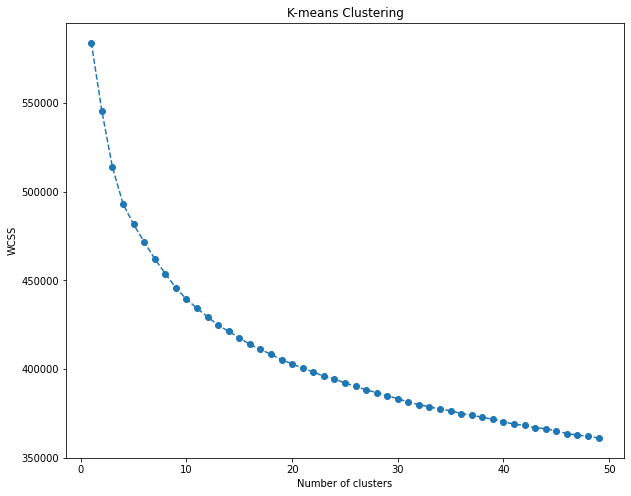

In [167]:
plt.figure(figsize=(10,8))
plt.plot(range(1,50), wcss, marker = 'o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [154]:
abstracts_embeddings = sbert_model.encode(abstracts_df['abstracts_cleaned'])

In [174]:
import pickle

with open("./data/abstracts-bert-embeddings.pkl", "wb+") as fo:
    pickle.dump(abstracts_embeddings, fo)

In [76]:
from sklearn.cluster import KMeans

In [131]:
clustering_model = KMeans(n_clusters=30)

In [132]:
clustering_model.fit(abtracts_embeddings)
cluster_assignment = clustering_model.labels_

In [133]:
clustered_sentences = [[] for i in range(30)]
for abstract_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append({ 'abstract': abstracts_df.iloc[abstract_id]['abstracts'], 
                                             'druid': abstracts_df.iloc[abstract_id]['druids'] })

In [134]:
for i,row in enumerate(clustered_sentences):
    print(f"Cluster {i} size {len(row)}")

Cluster 0 size 114
Cluster 1 size 169
Cluster 2 size 197
Cluster 3 size 186
Cluster 4 size 248
Cluster 5 size 210
Cluster 6 size 129
Cluster 7 size 113
Cluster 8 size 270
Cluster 9 size 247
Cluster 10 size 197
Cluster 11 size 112
Cluster 12 size 249
Cluster 13 size 163
Cluster 14 size 258
Cluster 15 size 170
Cluster 16 size 264
Cluster 17 size 285
Cluster 18 size 270
Cluster 19 size 247
Cluster 20 size 225
Cluster 21 size 309
Cluster 22 size 190
Cluster 23 size 277
Cluster 24 size 235
Cluster 25 size 199
Cluster 26 size 126
Cluster 27 size 203
Cluster 28 size 207
Cluster 29 size 215


In [138]:
print(clustered_sentences[17][0])
print(f"Last abstract")
print(clustered_sentences[17][-1])

{'abstract': "Biological research is highly visual, as advances in imaging technologies over the last few decades have enabled biologists to discern increasingly specific structures using fluorescence microscopy. However, two obstacles limit the amount of information that can be extracted from images. The first is the diffraction limit, the fundamental limit that dictates how small of an object can be resolved by light waves. The second challenge is the necessity to efficiently and objectively process the large numbers of images that today's technology can acquire. Current research in the fields of image processing and computer vision is not directly applicable to biological images, because it focuses primarily on extracting information from natural images with strong features. This dissertation leverages some of these engineering techniques to create two tools to address the challenges of visual biological research in the context of neuronal transport. These tools incorporate techniqu

In [102]:
pairwise_similarities=cosine_similarity(abtracts_embeddings)

In [62]:
pairwise_similarities

array([[0.99999976, 0.5214916 , 0.55871594, ..., 0.69063044, 0.5993461 ,
        0.6503042 ],
       [0.5214916 , 1.0000002 , 0.6672558 , ..., 0.6447394 , 0.52439696,
        0.5758405 ],
       [0.55871594, 0.6672558 , 0.9999999 , ..., 0.6357577 , 0.51056916,
        0.66535485],
       ...,
       [0.69063044, 0.6447394 , 0.6357577 , ..., 1.0000001 , 0.6003269 ,
        0.7389338 ],
       [0.5993461 , 0.52439696, 0.51056916, ..., 0.6003269 , 1.0000002 ,
        0.6041701 ],
       [0.6503042 , 0.5758405 , 0.66535485, ..., 0.7389338 , 0.6041701 ,
        0.99999994]], dtype=float32)

In [66]:
def most_similar_bert(doc_id: int, similarity_matrix: np.ndarray, matrix: str) -> None:
    print(f"Document: {abstracts_df.iloc[doc_id]['abstracts']}\n")
    print("Similar Documents")
    if matrix.startswith("Cosine Similarity"):
        similar_index_array = np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix.startswith("Euclidean Distance"):
        similar_index_array = np.argsort(similarity_matrix[doc_id])
    for index_ in similar_index_array[0:15]:
        if index_ == doc_id:
            continue
        print(f"\nDocument: {abstracts_df.iloc[index_]['abstracts']}")
        print(f"{matrix} : {similarity_matrix[doc_id][index_]}")

# Running BERT Cluster on all Full-text ETDs

In [2]:
etds = pathlib.Path("../tmp/etds")
etd_paths = []

In [3]:
for row in etds.iterdir():
    if row.is_dir() or not row.name.endswith("txt"):
        continue
    etd_paths.append(row)

In [4]:
all_etds = [[etd.name[:-4], etd.read_text()] for etd in etd_paths]

In [6]:
etds_df = pd.DataFrame(all_etds, columns=['druids', 'full_text'])

In [11]:
import datetime
def clean_fulltext():
    start = datetime.datetime.utcnow()
    etds_df['cleaned_full_text'] = etds_df.full_text.apply(cleanup)
    end = datetime.datetime.utcnow()
    print(f"Finished at {end} total time {(end-start).seconds / 60.} mins")
clean_fulltext()

Finished at 2020-10-23 22:19:54.510016 total time 12.166666666666666 mins


In [12]:
def bert_embeddings(data_frame):
    start = datetime.datetime.utcnow()
    print(start)
    text_embeddings = sbert_model.encode(data_frame['cleaned_full_text'])
    end = datetime.datetime.utcnow()
    print(f"Finished at {end} total time {(end-start).seconds / 60.} mins")
    return text_embeddings

In [15]:
full_text_embeddings = bert_embeddings(etds_df)

2020-10-23 22:26:01.131906


KeyboardInterrupt: 

In [17]:
etds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283 entries, 0 to 6282
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   druids             6283 non-null   object
 1   full_text          6283 non-null   object
 2   cleaned_full_text  6283 non-null   object
dtypes: object(3)
memory usage: 147.4+ KB
